In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
patient_hup_id = 142
TABLES_DIRECTORY = "../../Data/giant_new_tables"
hourly_patient_features_df = pd.read_csv(
    os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
)

## Figure 1: Curves

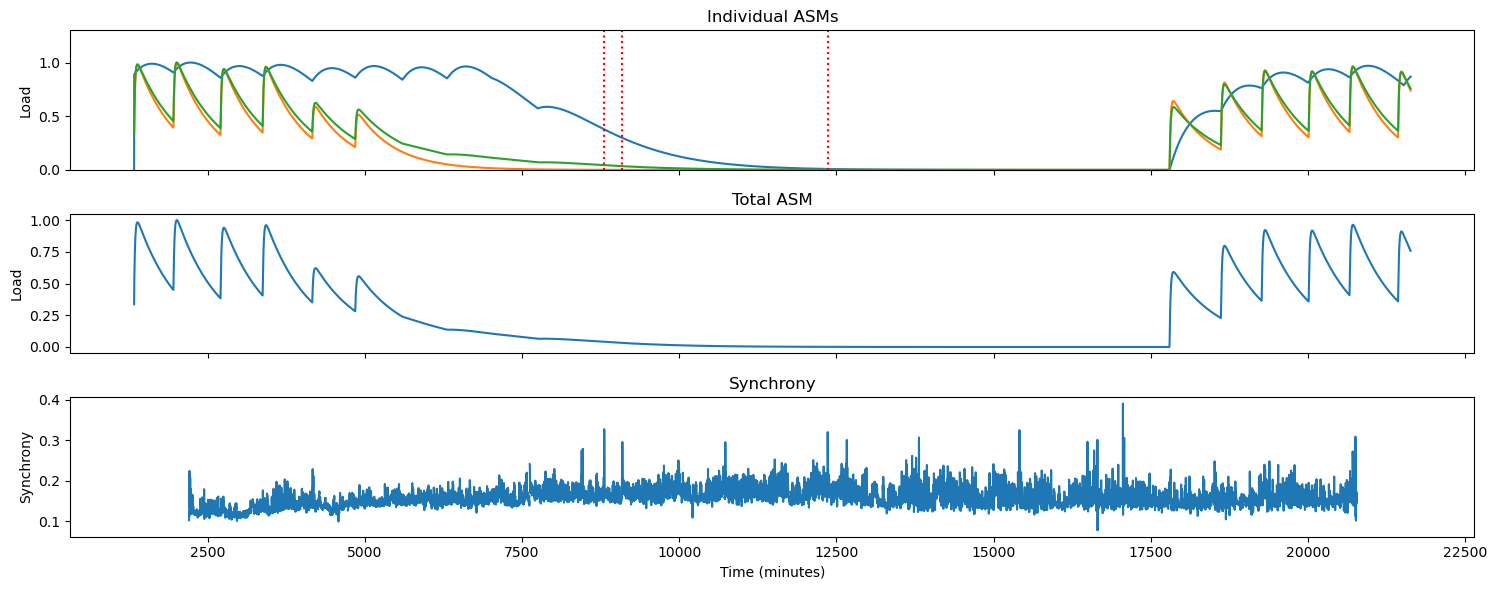

In [3]:
med_cols = [
    col
    for col in hourly_patient_features_df.columns
    if col.startswith("med_") and not hourly_patient_features_df[col].eq(0).all()
]
med_cols_no_raw = [col.split("_raw")[0] for col in med_cols]

fig, ax = plt.subplots(3, 1, figsize=(15, 6), sharex=True)

# Plotting Individual ASMs
for i, col in enumerate(med_cols):
    if col != "med_sum_no_lorazepam_raw":
        label = med_cols_no_raw[i].replace("med_", "")
        normalized_data = (
            hourly_patient_features_df[col] / hourly_patient_features_df[col].max()
        )
        ax[0].plot(
            hourly_patient_features_df["emu_minute"], normalized_data, label=label
        )

seizure_minutes = hourly_patient_features_df[
    hourly_patient_features_df["had_seizure"] >= 1
]["emu_minute"].values
for idx in seizure_minutes:
    ax[0].axvline(x=idx, color="red", linestyle="dotted")

ax[0].set_ylabel("Load")
ax[0].set_ylim([0, 1.3])
# ax[0].legend()
ax[0].set_title("Individual ASMs")

ax[1].plot(
    hourly_patient_features_df["emu_minute"],
    hourly_patient_features_df["med_sum_no_lorazepam_raw"],
)
ax[1].set_ylabel("Load")
ax[1].set_title("Total ASM")

# Plotting synchrony (broadband Band)
ax[2].plot(
    hourly_patient_features_df["emu_minute"],
    hourly_patient_features_df["synchrony_broadband"],
)
ax[2].set_ylabel("Synchrony")
ax[2].set_title("Synchrony")

ax[2].set_xlabel("Time (minutes)")
plt.tight_layout()
plt.show()

## Figure 2: Baseline synchrony vs ASM

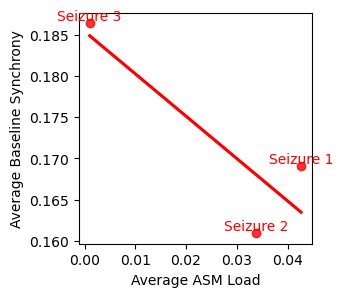

In [4]:
# Assuming you have the hourly_patient_features_df from somewhere above
seizure_indices = hourly_patient_features_df[
    hourly_patient_features_df["had_seizure"] >= 1
].index

valid_seizure_indices = [
    idx
    for i, idx in enumerate(seizure_indices)
    if i == 0 or (seizure_indices[i] - seizure_indices[i - 1]) >= 120
]

avg_synchronies = []
avg_med_loads = []

for idx in valid_seizure_indices:
    seizure_time = hourly_patient_features_df.loc[idx, "emu_minute"]

    window = hourly_patient_features_df[
        (hourly_patient_features_df["emu_minute"] >= seizure_time - 120)
        & (hourly_patient_features_df["emu_minute"] < seizure_time - 20)
    ]

    avg_synchrony = np.nanmean(window["synchrony_broadband"])
    avg_med_load = np.nanmean(window["med_sum_no_lorazepam_raw"])

    avg_synchronies.append(avg_synchrony)
    avg_med_loads.append(avg_med_load)

if avg_med_loads and avg_synchronies:
    plt.figure(figsize=(3, 3))  # Add this line to create a standalone figure
    sns.regplot(
        x=avg_med_loads,
        y=avg_synchronies,
        scatter=True,
        line_kws={"color": "red"},
        ci=None,
        color="red",
    )

    # Label each dot with its respective seizure number
    for i, (x, y) in enumerate(zip(avg_med_loads, avg_synchronies)):
        plt.text(
            x, y, f"Seizure {i+1}", fontsize=10, ha="center", va="bottom", color="red"
        )

    plt.xlabel("Average ASM Load")
    plt.ylabel("Average Baseline Synchrony")
    # plt.title(f"Baseline Synchrony vs ASM")
    plt.show()  # Add this line to display the plot

## ASM Taper Period subplots

### Daily Increase in Synchrony

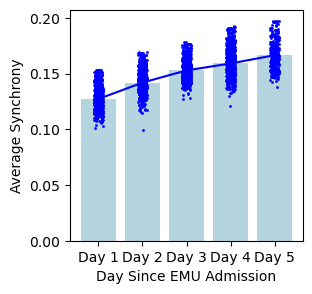

In [5]:
# Assuming you have hourly_patient_features_df and hup_id from somewhere above
taper_start_idx = hourly_patient_features_df[
    ~hourly_patient_features_df["synchrony_broadband"].isna()
].index[0]
taper_end_idx = hourly_patient_features_df[
    hourly_patient_features_df["had_seizure"] >= 1
].index[0]

taper_period = hourly_patient_features_df.loc[taper_start_idx:taper_end_idx]

# Given each row represents 2 minutes, there are 720 rows per day
rows_per_day = 720

day_avgs = []
day_data_list_of_lists = []
days = len(taper_period) // rows_per_day + 1  # Number of days (rounded up)
for i in range(days):
    day_data = taper_period["synchrony_broadband"].iloc[
        i * rows_per_day : (i + 1) * rows_per_day
    ]
    # Drop values in day_data that are larger than 95th percentile
    day_data = day_data[day_data < day_data.quantile(0.95)]
    top_half_data = day_data.dropna().nlargest(rows_per_day // 2)
    day_avgs.append(np.nanmean(day_data))
    day_data_list_of_lists.append(day_data)

plt.figure(figsize=(3, 3))  # Create a standalone figure

# Plot the bars
sns.barplot(x=list(range(1, days + 1)), y=day_avgs, errorbar="sd", color="lightblue")

# Plot the individual data points using stripplot
for i, day_data in enumerate(day_data_list_of_lists):
    sns.stripplot(
        x=[i + 1] * len(day_data), y=day_data, color="blue", size=2, jitter=True
    )

# Plot trend line connecting the bars, with marker size being large"
plt.plot(range(days), day_avgs, marker="o", linestyle="-", color="blue")

plt.xlabel("Day Since EMU Admission")
plt.xticks(range(days), [f"Day {i+1}" for i in range(days)])
plt.ylabel("Average Synchrony")
# plt.title("Daily Synchrony during Taper Period")
plt.show()  # Display the plot

### Taper Distribution Shift

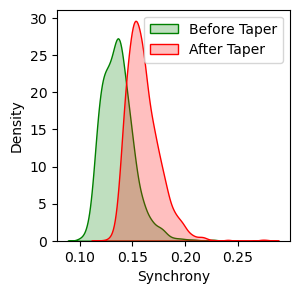

In [6]:
# 2. Create a separate figure for the KDE plots
plt.figure(figsize=(3, 3))

# Fetch the taper_start_time for this patient
taper_start_time = 5000

# Define the first seizure time after taper_start_time
first_seizure_time = hourly_patient_features_df[
    (hourly_patient_features_df["emu_minute"] > taper_start_time)
    & (hourly_patient_features_df["had_seizure"] >= 1)
]["emu_minute"].min()

# Get 'after' period (time between taper_start_time and first_seizure_time)
after_period = hourly_patient_features_df[
    (hourly_patient_features_df["emu_minute"] >= taper_start_time)
    & (hourly_patient_features_df["emu_minute"] < first_seizure_time)
]
after_synchronies = after_period["synchrony_broadband"].values

# Determine the 'before' period based on the length of the 'after' period
# Ensure that we remove any rows with NaN values in 'synchrony_broadband'
before_period = hourly_patient_features_df[
    (hourly_patient_features_df["emu_minute"] < taper_start_time)
    & (~hourly_patient_features_df["synchrony_broadband"].isna())
].tail(len(after_synchronies))
before_synchronies = before_period["synchrony_broadband"].values

sns.kdeplot(before_synchronies, fill=True, color="green", label="Before Taper")
sns.kdeplot(after_synchronies, fill=True, color="red", label="After Taper")

plt.xlabel("Synchrony")
plt.ylabel("Density")
# plt.title("ASM Taper Shifts Synchrony Distribution")
plt.legend()
plt.show()

## ASM Reinitiation Period

### Daily Decrease in Synchrony

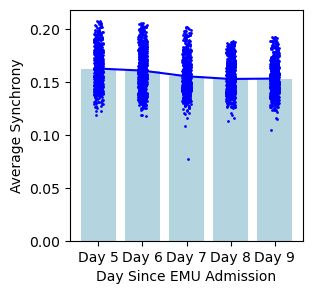

In [7]:
reinitiation_start_time = 12500

reinitiation_start_idx = hourly_patient_features_df[
    hourly_patient_features_df["emu_minute"] >= reinitiation_start_time
].index[0]

# Use end of dataframe as the end index
end_idx = hourly_patient_features_df.index[-1]

reinitiation_period = hourly_patient_features_df.loc[reinitiation_start_idx:end_idx]

# Given each row represents 2 minutes, there are 720 rows per day
rows_per_day = 720

day_avgs = []
day_data_list_of_lists = []
days = len(reinitiation_period) // rows_per_day - 1  # Number of full days
for i in range(days):
    day_data = reinitiation_period["synchrony_broadband"].iloc[
        i * rows_per_day : (i + 1) * rows_per_day
    ]
    # Drop values in day_data that are larger than 95th percentile
    day_data = day_data[day_data < day_data.quantile(0.95)]
    top_half_data = day_data.dropna().nlargest(rows_per_day // 2)
    day_avgs.append(np.nanmean(day_data))
    day_data_list_of_lists.append(day_data)

plt.figure(figsize=(3, 3))  # Create a standalone figure

# Plot the bars
sns.barplot(x=list(range(1, days + 1)), y=day_avgs, errorbar="sd", color="lightblue")

# Plot the individual data points using stripplot
for i, day_data in enumerate(day_data_list_of_lists):
    sns.stripplot(
        x=[i + 1] * len(day_data), y=day_data, color="blue", size=2, jitter=True
    )

# Plot trend line connecting the bars, with marker size being large
plt.plot(range(days), day_avgs, marker="o", linestyle="-", color="blue")

plt.xlabel("Day Since EMU Admission")
plt.xticks(range(days), [f"Day {i+5}" for i in range(days)])
plt.ylabel("Average Synchrony")
# plt.title("Daily Synchrony during Reinitiation Period")
plt.show()  # Display the plot

### Reinitiation Distribution Shift

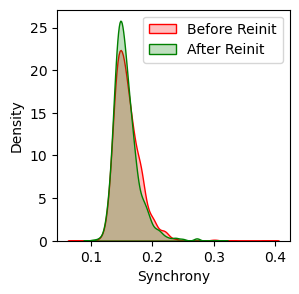

In [8]:
# 2. Create a separate figure for the KDE plots
plt.figure(figsize=(3, 3))

# Fetch the reinitiation_start_time for this patient
reinitiation_start_time = 17000

# Get 'after' period
after_period = hourly_patient_features_df[
    (hourly_patient_features_df["emu_minute"] >= reinitiation_start_time)
    & (~hourly_patient_features_df["synchrony_broadband"].isna())
]
after_synchronies = after_period["synchrony_broadband"].values

# Determine the 'before' period based on the length of the 'after' period
before_period = hourly_patient_features_df[
    (hourly_patient_features_df["emu_minute"] < reinitiation_start_time)
].tail(len(after_synchronies))
before_synchronies = before_period["synchrony_broadband"].values

sns.kdeplot(before_synchronies, fill=True, color="red", label="Before Reinit")
sns.kdeplot(after_synchronies, fill=True, color="green", label="After Reinit")

plt.xlabel("Synchrony")
plt.ylabel("Density")
# plt.title("ASM Reinitiation Shifts Synchrony Distribution")
plt.legend()
plt.show()